In [1]:
import os
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import tensorflow as tf
import tensorflow_probability.substrates.jax as tfp
from astropy.table import Table

2023-09-30 02:51:37.763356: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tfd = tfp.distributions
rng = jax.random.PRNGKey(0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
from lcmcmc.preprocessing import add_object_band_index, preprocess_SNANA, extract_subsample

In [4]:
from lcmcmc.utils import get_data_dir_path

In [21]:
train_data_head_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_HEAD.FITS'
train_data_phot_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_PHOT.FITS'

In [23]:
df_head = Table.read(train_data_head_path, format='fits').to_pandas()
df_phot = Table.read(train_data_phot_path, format='fits').to_pandas()

In [24]:
np.sum(df_head['SNTYPE'].isin([151]))

2000

# Load PCs

In [28]:
from kndetect.utils import load_pcs

pcs = load_pcs()

In [29]:
data_dir = get_data_dir_path()

# Load fits

In [30]:
trained_features = pd.read_pickle(os.path.join(data_dir, "train", "train_0_data.pkl"))

In [31]:
original_features = pd.read_csv(os.path.join(data_dir, "train_features_original.csv"))

In [32]:
original_features

,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,coeff1_g,coeff2_g,coeff3_g,...,coeff2_r,coeff3_r,residuo_r,maxflux_r,key,type,type_names,y_true,y_pred,y_score
0,0,0,0,0,0,0,0,0.290510,0.095632,0.074392,...,0.113414,0.075967,1.964267,373.748047,1757,150,150: KN GW170817,True,True,0.948956
1,1,1,1,1,1,1,1,0.514803,0.116128,-0.073609,...,-0.065936,-0.210053,1.474833,788.683228,6415,141,141: 91BG,False,False,0.000000
2,2,2,2,2,2,2,2,1.067839,-0.114932,0.315341,...,-0.036559,0.173198,0.974568,518.246521,7707,103,103: Core collapse Type Ibc,False,False,0.000000
3,3,3,3,3,3,3,4,0.785228,0.026194,-0.227322,...,-0.199459,-0.287732,0.937045,291.099426,12578,102,102: MOSFIT-Ibc,False,False,0.000000
4,4,4,4,4,4,4,5,0.516106,0.123479,-0.052812,...,0.128943,-0.032813,0.905214,383.834531,15888,149,149: KN GRANDMA,True,True,0.837588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19501,19501,19501,19501,19501,19501,19501,22275,1.088962,-0.014523,0.106654,...,-0.059662,0.725981,1.578576,666.974243,137062467,112,112: Core collapse Type II,False,False,0.000000
19502,19502,19502,19502,19502,19502,19502,22276,0.978098,-0.118905,-0.022548,...,-0.084343,0.017370,1.344228,1213.934937,137071784,170,170: AGN,False,False,0.000000
19503,19503,19503,19503,19503,19503,19503,22277,0.934356,-0.129008,-0.007231,...,-0.036172,-0.020847,0.761197,408.148193,137071978,143,143: Iax,False,False,0.000000
19504,19504,19504,19504,19504,19504,19504,22278,0.206614,0.121759,0.131741,...,0.283979,-0.027413,1.448031,445.314880,137079473,151,151: KN Karsen 2017,True,True,0.944313


# Display results from 10 fits

In [33]:
import matplotlib.pyplot as plt
from lcmcmc.parametric_fits import parametric_fn_pcs

In [34]:
import seaborn as sns

     Unnamed: 0.6  Unnamed: 0.5  Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2   
963           963           963           963           963           963  \

     Unnamed: 0.1  Unnamed: 0  coeff1_g  coeff2_g  coeff3_g  ...  coeff2_r   
963           963        1156  0.846336  0.036925 -0.019506  ...  0.000743  \

     coeff3_r  residuo_r   maxflux_r      key  type       type_names  y_true   
963 -0.000548   0.068185  529.687428  4161979   149  149: KN GRANDMA    True  \

     y_pred   y_score  
963    True  0.833333  

[1 rows x 23 columns]
1936     True
1937     True
1938    False
1939    False
Name: FLT, dtype: bool
381.0172312912383
1936    False
1937    False
1938     True
1939     True
Name: FLT, dtype: bool
529.6874277381905


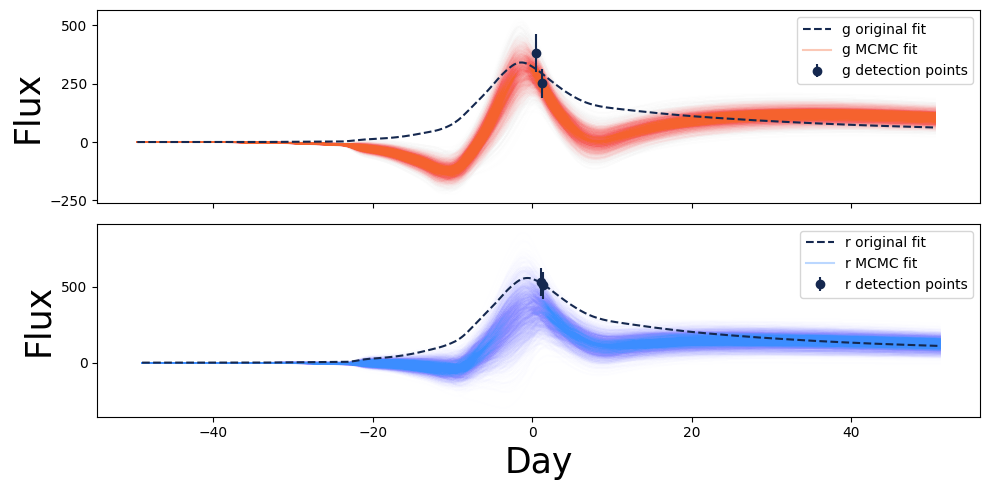

In [35]:
colors = ['#F5622E', '#3C8DFF']
snid = 4161979 
plot_sample = trained_features[trained_features["SNID"]==snid]
#plot_sample = trained_features.sample(, random_state=3)
for index, row in plot_sample.iterrows():
    
    current_original_features = original_features[original_features['key']==row['SNID']]
    
    if len(current_original_features)==0:
        continue
        
    print(current_original_features)

    current_obj_df = {}
    norm_fact = np.array([row['norm_factor']]*2000)

    features = np.concatenate((row['MCMC_samples_kn'], np.expand_dims(np.mean(row['data-likelihood']['data_value'], axis=2), 2)), axis=2).reshape((2000, 7))

    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 5))

    for band_num, band in enumerate(['g', 'r']):
        for coeff_num in range(3):
            current_obj_df[f"{band}coeff{coeff_num}"] = features[:, band_num*3+coeff_num]
    current_obj_df["likelihood"] = features[:, 6]

    current_obj_df["g_norm"] = norm_fact[:, 0]
    current_obj_df["r_norm"] = norm_fact[:, 1]

    current_obj_df=pd.DataFrame(current_obj_df)

    event_type = df_head[row['SNID']==df_head["SNID"]]["SNTYPE"].values[0]
    
    event_df = df_phot[df_phot['SNID'] == row['SNID']]
    
    max_time = row['max_time']
    if len(max_time) == 1:
            max_time = max_time*2
    
    for band_num, band in enumerate([b'g', b'r']):
        print(event_df['FLT'] == band)
        band_df = event_df[event_df['FLT'] == band]
        print(norm_fact[0, band_num])
        
        for pred_num in range(2000):

            #print(mcmc_samples[0].shape)
            c1 = features[pred_num, 0 + band_num*3]
            c2 = features[pred_num, 1 + band_num*3]
            c3 = features[pred_num, 2 + band_num*3]

            predictions = parametric_fn_pcs(c1, c2, c3, pcs, np.arange(0,401, 1))
            
            ax[band_num].plot(np.arange(-50, 50.25, .25)+max_time[band_num], predictions*norm_fact[0, band_num], alpha=.005,color=colors[band_num])
            
        bname = 'g' if band_num==0 else 'r'

        c1_o = current_original_features[f"coeff{1}_"+bname].values[0]
        c2_o= current_original_features[f"coeff{2}_"+bname].values[0]
        c3_o= current_original_features[f"coeff{3}_"+bname].values[0]

        predictions = parametric_fn_pcs(c1_o, c2_o, c3_o, pcs, np.arange(0,401, 1))
        ax[band_num].plot(np.arange(-50, 50.25, .25)+max_time[band_num], predictions*norm_fact[0, band_num], alpha=1, ls="--",color="#15284F", label=f"{bname} original fit")
        
        if len(band_df)>0:
            ax[band_num].errorbar(band_df["MJD"], band_df["FLUXCAL"], yerr=band_df['FLUXCALERR'], fmt="o", color="#15284F", label=f"{bname} detection points")
            
        ax[band_num].plot([], [],  alpha=.35,color=colors[band_num], label=f"{bname} MCMC fit")
        
        ax[band_num].legend()
        
        
        ax[band_num].set_ylabel("Flux", fontsize=25)
    
    ax[1].set_xlabel("Day", fontsize=25)
    if event_type in [149, 150]:
        current_obj_df["type"]=1
        
        
    plt.rc('xtick', labelsize=17)    
    plt.rc('ytick', labelsize=17) 
        
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    plt.savefig(os.path.join(get_data_dir_path(), "fit_example.png"))
    
    plt.show()

    #features_df.append(current_obj_df)

In [36]:
np.arange(2000)

array([   0,    1,    2, ..., 1997, 1998, 1999])

NOTE that the flux values are normalized. 
To get the actual values, multiply flux and fluxerr columns with norm_factor

In [ ]:
@jax.jit
def run_mcmc_sampling(index, x_range, pcs, mu, scale, observed_sigma, observed_value, rng):
    jd = jd_model_pcs(index, x_range, pcs, mu, scale)
    pinned_jd = jd.experimental_pin(sigma=observed_sigma, obs=observed_value)
    
    # Run the mcmc
    run_mcmc = jax.jit(
        lambda seed: tfp.experimental.mcmc.windowed_adaptive_nuts(
            1000, 
            pinned_jd, 
            n_chains=4, 
            seed=seed,
        )
    )

    rng, sample_rng = jax.random.split(rng, 2)
    mcmc_samples, sampler_stats = run_mcmc(sample_rng)
  
    axes_swapped_mcmc_samples = jax.tree_map(lambda x: np.swapaxes(x, 1, 0), mcmc_samples)

    data_likelihood = jax.vmap(
        jax.vmap(
            lambda x: return_data_loglike(x, obs, pinned_jd)
        )
    )(mcmc_samples)

#     compare_data = az.from_dict(
#         posterior=axes_swapped_mcmc_samples._asdict(),
#         sample_stats={
#             k:np.swapaxes(sampler_stats[k], 1, 0)
#             for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]},
#         log_likelihood=data_likelihood,
#     )

    return mcmc_samples, sampler_stats, data_likelihood

In [ ]:
@jax.jit 
def compute_snr(flux, fluxerr):
    return flux/fluxerr

In [ ]:
kn_snids = df_head[df_head['SNTYPE']==150]['SNID']

In [ ]:
pd.options.mode.chained_assignment = None 
mcmc_samples_kn_prior=[]
mcmc_samples_non_kn_prior=[]
snid_list=[]
sampler_stats_list_kn = []
sampler_stats_list_non_kn = []
norm_factor_list=[]
max_flux_date_list = []
compare_res = []

# for snid in df_head["SNID"].values[:10]:
for snid in kn_snids[:10]:  
    
    compare_dict = {}

    current_df = df_phot[df_phot["SNID"] == snid]
    current_df = add_object_band_index(current_df, bands=[b'g', b'r'])
    
    current_df_head = df_head[df_head["SNID"]==snid]
    
    detection_points = current_df[(current_df["PHOTFLAG"] == 4096) | (current_df["PHOTFLAG"] == 999999)]
    max_snr_loc = np.argmax(comdetection_points["FLUXCAL"].values/detection_points["FLUXCALERR"].values)
    max_snr_date = detection_points["MJD"].values[max_snr_loc]
    
    current_df = current_df[(current_df["MJD"]>= (max_snr_date - 10)) & (current_df["MJD"]<= (max_snr_date +20))]

    normed_current_df = preprocess_SNANA(df_head=current_df_head, df_phot=current_df, bands=[b'g', b'r'], norm_band_index=None)
    
    index = np.zeros((len(normed_current_df), 2), dtype=np.int32)

    index[:, 0] = np.asarray(normed_current_df["object_index"].values)
    index[:, 1] = np.asarray(normed_current_df["band_index"].values)

    x_range = jnp.asarray(normed_current_df["time"])

    observed_value = jnp.array(np.asarray(normed_current_df["flux"]), dtype=jnp.float32)
    observed_sigma = jnp.array(np.asarray(normed_current_df["fluxerr"]), dtype=jnp.float32)

    # use KN prior 
     
    mcmc_samples, sampler_stats, data_likelihood = run_mcmc_sampling(
        index=index, 
        x_range=x_range, 
        pcs=pcs, 
        mu=mu_kn, 
        scale=scale_kn, 
        observed_sigma=observed_sigma, 
        observed_value=observed_value,
        rng=rng,
    )

    sampler_stats_list_kn.append(sampler_stats)
    mcmc_samples_kn_prior.append(mcmc_samples[0])

    # use non-KN prior 
#     pinned_jd, mcmc_samples, sampler_stats, compare_data = run_mcmc_sampling(
#         index=index, 
#         x_range=x_range, 
#         pcs=pcs, 
#         mu=mu_non_kn, 
#         scale=scale_non_kn, 
#         observed_sigma=observed_sigma, 
#         observed_value=observed_value,
#         rng=rng,
#     ) 

    
#     compare_dict["model_non_kn"] = compare_data
#     compare_res.append(compare_dict)
#     mcmc_samples_non_kn_prior.append(mcmc_samples[0])
#     sampler_stats_list_non_kn.append(sampler_stats)
    
    snid_list.append(snid)
    norm_factor_list.append(normed_current_df['norm_factor'][0])
    max_flux_date_list.append(normed_current_df['max_time'][0])


In [ ]:
#mcmc_samples_df = pd.DataFrame({'SNID': snid_list, 'MCMC_samples_kn': mcmc_samples_kn_prior, 'MCMC_samples_non_kn': mcmc_samples_non_kn_prior, 'norm_factor': norm_factor_list , 'sampler_stats_kn': sampler_stats_list_kn, 'sampler_stats_non_kn': sampler_stats_list_non_kn})
mcmc_samples_df = pd.DataFrame({'SNID': snid_list, 'MCMC_samples_kn': mcmc_samples_kn_prior, 'norm_factor': norm_factor_list , 'sampler_stats_kn': sampler_stats_list_kn, 'max_time':max_flux_date_list})

In [ ]:
#az.compare(compare_res[0])

In [ ]:
compare_res[0]['model_kn'].log_likelihood

In [ ]:
az.plot_kde(compare_res[0]['model_kn'].log_likelihood)

In [ ]:
loo = az.loo(compare_res[0]['model_non_kn'], pointwise=True)
az.plot_khat(loo)

In [ ]:
mcmc_samples_df.to_pickle("training_data.pkl")

In [ ]:
read_data = pd.read_pickle("training_data.pkl")

In [ ]:
print(read_data)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
colors = ['r', 'g']
for index, row in read_data.iterrows():
    print(row)
    snid = row["SNID"]
    print(snid)
    
    event_num=0

    current_df_head = df_head[df_head["SNID"] == snid]
    current_df_phot = df_phot[df_phot["SNID"] == snid]
    
    for band_num, band in enumerate([b'g', b'r']):

        band_df = current_df_phot[current_df_phot['FLT']==band]

        plt.errorbar(band_df["MJD"], band_df["FLUXCAL"], yerr=band_df["FLUXCALERR"], fmt="o", color=colors[band_num])
        
        band_max_date = band_df["MJD"].values[np.argmax(band_df["FLUXCAL"].values)]
        for sample_no in range(100):

            sample_no = sample_no + 900
            for chain_num in range(4):

                mcmc_samples = mcmc_samples_df['MCMC_samples_kn'][0]
                #print(mcmc_samples[0].shape)
                c1 = mcmc_samples[sample_no, chain_num, event_num, 0 + band_num*3]
                c2 = mcmc_samples[sample_no, chain_num, event_num, 1 + band_num*3]
                c3 = mcmc_samples[sample_no, chain_num, event_num, 2 + band_num*3]
                
                predictions = parametric_fn_pcs(c1, c2, c3, pcs, np.arange(0,401, 1))
                plt.plot(
                    np.arange(-50, 50.25, .25)+mcmc_samples_df['max_time'][0][band_num],
                    predictions*mcmc_samples_df['norm_factor'][0][band_num], 
                    alpha=.01, 
                    color=colors[band_num],
                )

        
    break
    
    print(current_df_head)
    print(current_df_phot['FLT'])
    

In [ ]:
mcmc_samples_df['MCMC_samples_kn']

In [ ]:
colors = ['r', 'g']
num_plot=10
for event_num in range(len(read_data)):
    print(event_num)
    plt.figure()
    object_df = normed_current_df[normed_current_df['object_index']==event_num]
    for band in range(2):
        for sample_no in range(100):
            sample_no = sample_no + 900
            for chain_num in range(4):
                mcmc_samples = mcmc_samples_df['MCMC_samples_kn'][0]
                #print(mcmc_samples[0].shape)
                c1 = mcmc_samples[sample_no, chain_num, event_num, 0 + band*3]
                c2 = mcmc_samples[sample_no, chain_num, event_num, 1 + band*3]
                c3 = mcmc_samples[sample_no, chain_num, event_num, 2 + band*3]
                
                predictions = parametric_fn_pcs(c1, c2, c3, pcs, np.arange(0,401, 1))
                plt.plot(np.arange(-50, 50.25, .25), predictions, alpha=.01, color=colors[band])

        band_df = object_df[object_df['band_index']==band]
        plt.errorbar(band_df["time"], band_df["flux"], yerr=band_df["fluxerr"], fmt="o", color=colors[band])

    
    plt.show()
    break

In [ ]:
colors = ['r', 'g']
num_plot=10
for event_num in [0]:
    print(event_num)
    plt.figure()
    object_df = normed_current_df[normed_current_df['object_index']==event_num]
    for band in range(2):
        for sample_no in range(100):
            sample_no = sample_no + 900
            for chain_num in range(4):
                mcmc_samples = mcmc_samples_df['MCMC_samples_kn'][0]
                #print(mcmc_samples[0].shape)
                c1 = mcmc_samples[sample_no, chain_num, event_num, 0 + band*3]
                c2 = mcmc_samples[sample_no, chain_num, event_num, 1 + band*3]
                c3 = mcmc_samples[sample_no, chain_num, event_num, 2 + band*3]
                
                predictions = parametric_fn_pcs(c1, c2, c3, pcs, np.arange(0,401, 1))
                plt.plot(np.arange(-50, 50.25, .25), predictions, alpha=.01, color=colors[band])
                
#                 c1 = mcmc_samples.coeffs_non_kn[sample_no, chain_num, event_num, 0 + band*3]
#                 c2 = mcmc_samples.coeffs_non_kn[sample_no, chain_num, event_num, 1 + band*3]
#                 c3 = mcmc_samples.coeffs_non_kn[sample_no, chain_num, event_num, 2 + band*3]
                
#                 predictions = parametric_fn_pcs(c1, c2, c3, pcs, np.arange(0,401, 1))
#                 plt.plot(np.arange(-50, 50.25, .25), predictions, alpha=.01, color=colors[band])


        band_df = object_df[object_df['band_index']==band]
        plt.errorbar(band_df["time"], band_df["flux"], yerr=band_df["fluxerr"], fmt="o", color=colors[band])

    
    plt.show()
    break